# Figure: bibiplots

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pickle
import matplotlib

import sparseRRR

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120     # only affects the notebook

sns_styleset()

In [2]:
def preprocess(data):
    X = data['counts'][:,data['mostVariableGenes']] / np.sum(data['counts'], axis=1) * 1e+6
    X = np.array(X)
    X = np.log2(X + 1)
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    Y = data['ephys']
    Y = Y - np.mean(Y, axis=0)
    Y = Y / np.std(Y, axis=0)
    
    return (X,Y)

In [3]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    stop = False
        if stop:
            break

In [4]:
data = pickle.load(open('data/scala2020.pickle', 'rb'))
X,Y = preprocess(data)
genes = data['genes'][data['mostVariableGenes']]
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=.45, alpha=1)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

data = pickle.load(open('data/scala2019.pickle', 'rb'))
X,Y = preprocess(data)
genes = data['genes'][data['mostVariableGenes']]
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=.95, alpha=.5)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

data = pickle.load(open('data/cadwell2016.pickle', 'rb'))
X,Y = preprocess(data)
genes = data['genes'][data['mostVariableGenes']]
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1.6, alpha=.5)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

data = pickle.load(open('data/gouwens2020.pickle', 'rb'))
X=data['counts'].toarray().astype('float64')
Y=data['ephys']
genes = data['genes']
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1.12, alpha=1)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

# Use ephys features to show on plot showing the 10 highest L2 correlation norm with sRRR component 1 and 2 
corr_norm=np.zeros((Y.shape[1],2))
for i in range(Y.shape[1]):
    corr_norm[i,0]=np.corrcoef(Y[:,i],(X@w)[:,0])[0,1]
    corr_norm[i,1]=np.corrcoef(Y[:,i],(X@w)[:,1])[0,1]
gouwens_2020_ephys_features_indices=np.argsort(np.linalg.norm(corr_norm, ord=2,axis=1))[-10:]
gouwens_2020_ephys_features_to_show=data['ephysNames'][gouwens_2020_ephys_features_indices]
print('\nConsistency check of gouwens2020 ephys names: \n')
print('gouwens2020 long ephys names to show: ', gouwens_2020_ephys_features_to_show)
gouwens_2020_ephys_features_to_show_short_names=np.array(['Spc2 AP1 dv', 'Spc1 thresh.', 'Tau', 'R_input', \
                                                          'Short sq. AP1 downstroke', 'Spc0 AP width', \
                                                          'Spc0 AP1 v', 'Rheobase', 'Short sq. AP1 UDR', \
                                                          'Spc0 UDR'])
print('gouwens2020 short ephys names to show: ', gouwens_2020_ephys_features_to_show_short_names)

Genes selected: 20
Genes selected: 20
Genes selected: 20
Genes selected: 20

Consistency check of gouwens2020 ephys names: 

gouwens2020 long ephys names to show:  ['spc2 first AP dv' 'spc1 spk. thr. v' 'tau' 'input resistance'
 'short sq. AP1 downstroke' 'spc0 spk. width' 'spc0 first AP v'
 'rheobase i' 'short sq. AP1 up-down ratio' 'spc0 spk. up-down ratio']
gouwens2020 short ephys names to show:  ['Spc2 AP1 dv' 'Spc1 thresh.' 'Tau' 'R_input' 'Short sq. AP1 downstroke'
 'Spc0 AP width' 'Spc0 AP1 v' 'Rheobase' 'Short sq. AP1 UDR' 'Spc0 UDR']


<IPython.core.display.Javascript object>


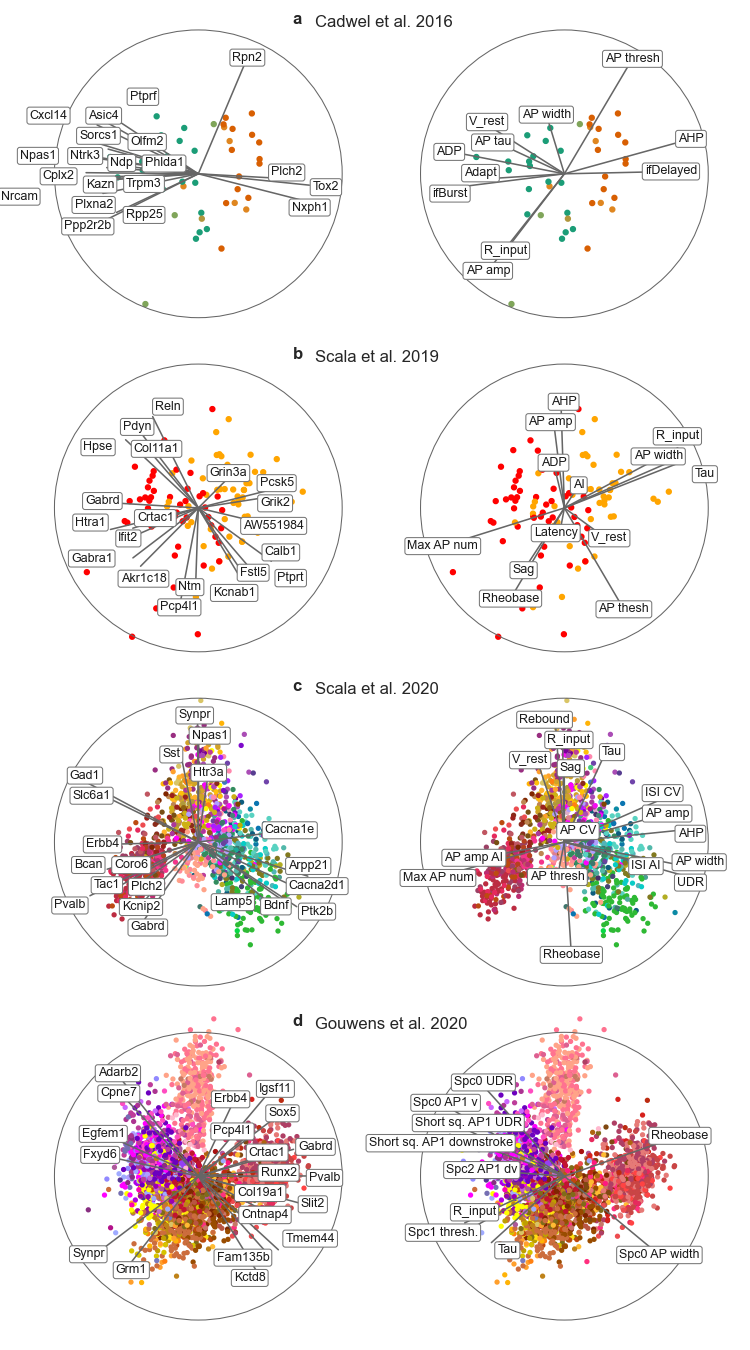

Text(0.42, 0.238, 'Gouwens et al. 2020')

In [5]:
fig = plt.figure(figsize=(5, 9))

titles = ['Cadwell et al. 2016', 'Scala et al. 2019', 'Scala et al. 2020', 'Gouwens et al. 2020']
files = ['cadwell2016.pickle', 'scala2019.pickle', 'scala2020.pickle', 'gouwens2020.pickle']
lambdas = [1.6, .95, .45, 1.12]
alphas = [.5, .5, 1, 1]
sizes = [5, 5, 3, 3]
scaleFactor = 3.5
xylim = 3.9

for dataset in range(4):
    if dataset==3:
        data = pickle.load(open('data/' + files[dataset], 'rb'))
        X=data['counts'].toarray().astype('float64')
        Y=data['ephys']
        genes = data['genes']
        w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=lambdas[dataset], 
                                                          alpha=alphas[dataset])
    else:
        data = pickle.load(open('data/' + files[dataset], 'rb'))
        X,Y = preprocess(data)
        genes = data['genes'][data['mostVariableGenes']]
        w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=lambdas[dataset], 
                                                          alpha=alphas[dataset])
    Zx = X @ w
    Zy = Y @ v
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)
    
    if dataset==0:
        colors = np.zeros((5,3))
        colors[0,:] = [217,95,2]
        colors[-1,:] = [27,158,119]
        for i in range(1,4):
            colors[i,:] = colors[0,:] * (5-i)/4 + colors[-1,:] * i/4
        colors = colors/256
        colors = [colors[t-1] for t in data['cellTypes']]
    elif dataset==1:
        colors = ['red' if t=='S1' else 'orange' for t in data['regions']]
    elif (dataset==2) | (dataset==3):
        colors = [data['colors'][t] for t in data['ttype']]
    
    plt.subplot(4, 2, (2*dataset)+1, aspect='equal')
    plt.scatter(Zy[:,0], Zy[:,1], s=sizes[dataset], color=colors)
    
    plt.ylim([-xylim, xylim])
    plt.xlim([-xylim, xylim])
    plt.xticks([])
    plt.yticks([])
    # plt.title(titles[dataset])
#     if dataset==0:
#         plt.ylabel('RNA expression', fontsize=7)

    labels = []
    L = np.corrcoef(np.concatenate((Zx[:,:2], X), axis=1), rowvar=False)[2:,:2]
    for i in np.where(w[:,0]!=0)[0]:
        plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
             zorder=1)
        t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], genes[i], 
             ha='center', va='center', color='k', fontsize=6,
             bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
        labels.append(t)
    adjustlabels(fig, labels)
    circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
    plt.gca().add_patch(circ)

    plt.subplot(4, 2, (2*dataset)+2, aspect='equal')
    plt.scatter(Zy[:,0], Zy[:,1], s=sizes[dataset], color=colors)
    
    plt.ylim([-xylim, xylim])
    plt.xlim([-xylim, xylim])
    plt.xticks([])
    plt.yticks([])

    labels = []
    L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
    if dataset==3:
        for j, i in enumerate(gouwens_2020_ephys_features_indices):
            plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
                 zorder=1)
            t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], gouwens_2020_ephys_features_to_show_short_names[j], 
                 ha='center', va='center', color='k', fontsize=6,
                 bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
            labels.append(t)
    else:
        for i in range(Y.shape[1]):
            plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
                 zorder=1)
            t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], data['ephysNames'][i], 
                 ha='center', va='center', color='k', fontsize=6,
                 bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
            labels.append(t)
    adjustlabels(fig, labels)
    circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
    plt.gca().add_patch(circ)
    
sns.despine(left=True, bottom=True)
plt.tight_layout()

fig.text(.39, .982, 'a', fontsize=8, fontweight='bold')
fig.text(.39, .734, 'b', fontsize=8, fontweight='bold')
fig.text(.39, .488, 'c', fontsize=8, fontweight='bold')
fig.text(.39, .24, 'd', fontsize=8, fontweight='bold')
fig.text(.42, .98, 'Cadwel et al. 2016', fontsize=8)
fig.text(.42, .732, 'Scala et al. 2019', fontsize=8)
fig.text(.42, .486, 'Scala et al. 2020', fontsize=8)
fig.text(.42, .238, 'Gouwens et al. 2020', fontsize=8)

plt.savefig('figures/bibiplots.png', dpi=200)
plt.savefig('figures/bibiplots.pdf')